# Projeto 14 - Deep Dream - Imagens Alucinógenas

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
base_model = tf.keras.applications.InceptionV3(include_top=False,
                                              weights='imagenet')

# Nota:
- O objetivo do algoritmo é selecionar uma camada para maximizar a loss function, que são as ativações
- Podemos selecionar qualquer camada, lembrando que as primeiras camadas possuem características mais simples (bordas) e camadas superiores possuem características mais complexas e detalhadas dos objetos
- A rede Inception possui múltiplas camadas concatenadas chamadas de 'mixed' 

In [3]:
names = ['mixed8', 'mixed9']
# names = ['mixed3', 'mixed5', 'mixed8', 'mixed9']
# names = ['mixed3', 'mixed5']
# names = ['mixed5']

In [4]:
layers = [base_model.get_layer(name).output for name in names] 
layers

[<tf.Tensor 'mixed8/concat:0' shape=(None, None, None, 1280) dtype=float32>,
 <tf.Tensor 'mixed9/concat:0' shape=(None, None, None, 2048) dtype=float32>]

In [5]:
deepdream_model = tf.keras.Model(inputs = base_model.input, outputs=layers)

In [6]:
sample_img = tf.keras.preprocessing.image.load_img(r'datasets/StaryNight.jpg', 
                                                  target_size=(225, 375))

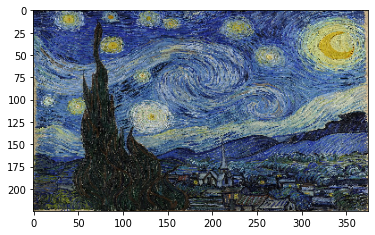

In [7]:
plt.imshow(sample_img)

In [8]:
type(sample_img)

PIL.Image.Image

In [9]:
sample_img = np.array(sample_img) / 255
type(sample_img), sample_img.shape

(numpy.ndarray, (225, 375, 3))

In [10]:
sample_img.max(), sample_img.min()

(1.0, 0.0)

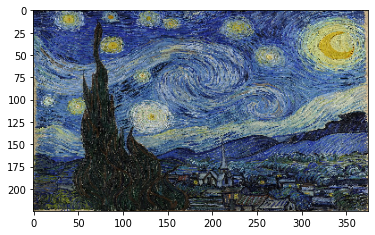

In [11]:
plt.imshow(sample_img);

In [12]:
sample_img = tf.keras.preprocessing.image.img_to_array(sample_img)
sample_img.shape, type(sample_img)

((225, 375, 3), numpy.ndarray)

In [13]:
sample_img  = tf.Variable(tf.keras.applications.inception_v3.preprocess_input(sample_img))
type(sample_img)

tensorflow.python.ops.resource_variable_ops.ResourceVariable

In [14]:
sample_img = tf.expand_dims(sample_img, axis=0)
np.shape(sample_img)

TensorShape([1, 225, 375, 3])

In [15]:
activations = deepdream_model(sample_img)

In [16]:
len(activations)

2

In [17]:
activations[0].shape

TensorShape([1, 5, 10, 1280])

# Calculando a Loss
- Calcularemos a loss que representa o somatório das ativações de uma camada específica
- Na maioria das vezes o objetivo é minizar o erro (loss) usando a descida gradiente, porém, em deep dream o objetivo é maximizar a loss 
- Isso é feito usando subida do gradiente (gradient ascent)
- A função encaminha a imagem pela rede neural e gera as ativações. Depois obtemos a soma das saídas

In [18]:
def calc_loss (img, model, test=1):
    if test == 1:
        img_batch = tf.expand_dims(img, axis=0)
        layers_activation = model(img_batch)
    else:
        layers_activation = model(img)
    
    losses = []
    for act in layers_activation:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
    
    print('Losses from multiple activation layer = ', losses)
    print('Loss shape: ', np.shape(losses))
    print('Sum of all Losses: ', tf.reduce_sum(losses))
    
    return(tf.reduce_sum(losses))

In [20]:
loss = calc_loss(sample_img, deepdream_model, test=0)

Losses from multiple activation layer =  [<tf.Tensor: shape=(), dtype=float32, numpy=0.14142309>, <tf.Tensor: shape=(), dtype=float32, numpy=0.051414967>]
Loss shape:  (2,)
Sum of all Losses:  tf.Tensor(0.19283806, shape=(), dtype=float32)


# Subida do Gradiente
- Vamos utilizar a loss calculada no passo anterior e calcular o gradiente com respeito a imagem de entrada. Depois adicionamos os valores na imagem de entrada


In [21]:
@tf.function
def deepdream(model, image, step_size):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = calc_loss(image, model)
    
    gradients = tape.gradient(loss, image)
    gradients /= tf.math.reduce_std(gradients)
    image = image + gradients * step_size
    image = tf.clip_by_value(image, -1, 1)
    
    return loss, image
    

In [22]:
def deprocess(image):
    image = 255 * (image + 1.) / 2.
    return tf.cast(image, tf.uint8)

In [25]:
def run_deepdream_simple_model(model, image, steps = 100, step_size=0.01):
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    for step in range(steps):
        loss, image = deepdream(model, image, step_size)
        
        if step % 250 == 0:
            plt.figure(figsize=(12, 12))
            plt.imshow(deprocess(image))
            plt.show()
            print('Step {}, loss {}'.format(step, loss))
#         plt.figure(figsize=(12,12))
#         plt.imshow(deprocess(image))
#         plt.show()
    return deprocess(image)

# Teste 

In [26]:
test_img = tf.keras.preprocessing.image.load_img(r'datasets/cat.jpg', 
                                                  target_size=(225, 375))

test_img = np.array(test_img)
# test_img = tf.keras.applications.inception_v3.preprocess_input(test_img)

In [27]:
np.shape(test_img)

(225, 375, 3)

Losses from multiple activation layer =  [<tf.Tensor 'Mean:0' shape=() dtype=float32>, <tf.Tensor 'Mean_1:0' shape=() dtype=float32>]
Loss shape:  (2,)
Sum of all Losses:  Tensor("Sum:0", shape=(), dtype=float32)


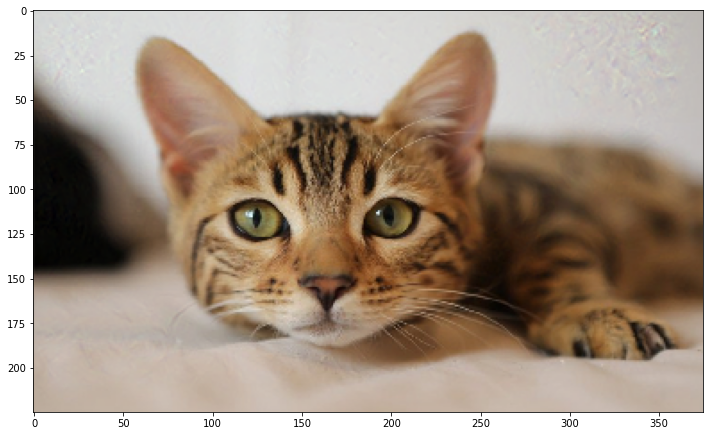

Step 0, loss 0.27787187695503235


KeyboardInterrupt: 

In [28]:
deep_img = run_deepdream_simple_model(model=deepdream_model,
                                     image=test_img,
                                     steps=1500, step_size=0.01)

# Execultando em mais dimensões


In [29]:
escala = 1.3
test_img2 = tf.keras.preprocessing.image.load_img(r'datasets/StaryNight.jpg', 
                                                  target_size=(225, 375))

# test_img2 = np.array(test_img2)
# test_img2 = tf.keras.applications.inception_v3.preprocess_input(test_img2)

image = tf.constant(np.array(test_img2))
base_shape = tf.cast(tf.shape(image)[:-1], tf.float32)

In [30]:
type(image)

tensorflow.python.framework.ops.EagerTensor

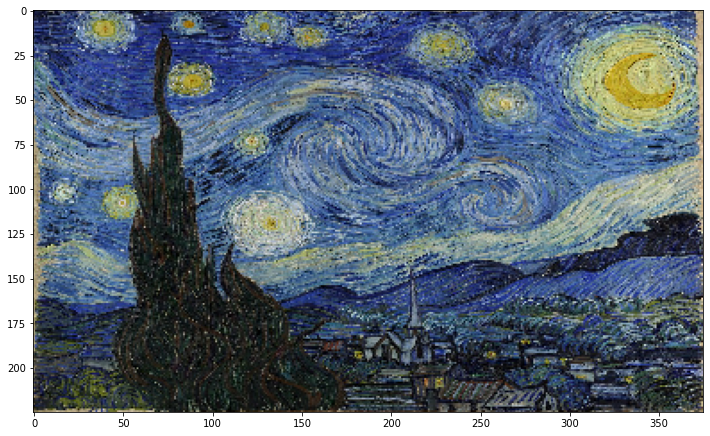

Step 0, loss 0.21851086616516113
Losses from multiple activation layer =  [<tf.Tensor 'Mean:0' shape=() dtype=float32>, <tf.Tensor 'Mean_1:0' shape=() dtype=float32>]
Loss shape:  (2,)
Sum of all Losses:  Tensor("Sum:0", shape=(), dtype=float32)


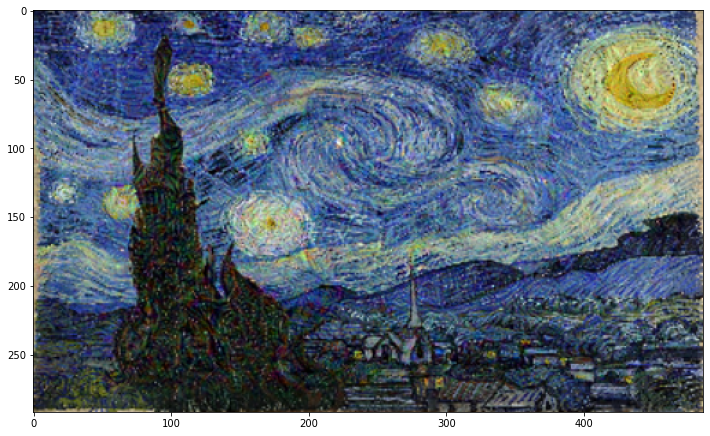

Step 0, loss 0.23118259012699127


KeyboardInterrupt: 

In [31]:
for n in range(5):
    new_shape = tf.cast(base_shape * (escala ** n), tf.int32)
    image = tf.image.resize(image, new_shape).numpy()
    image = run_deepdream_simple_model(model=deepdream_model, image=image, steps=100, step_size=0.01)